# Fashion-MNIST Classification: ANN vs CNN Comparison

This notebook implements and compares Artificial Neural Network (ANN) and Convolutional Neural Network (CNN) models for Fashion-MNIST classification.


## Student Name: Muhammad Jahanzaib Awan
## Student ID: P2926259

### Project Overview:
- **Dataset**: Fashion-MNIST (60K training, 10K test images, 28x28 grayscale)
- **Classes**: 10 clothing categories (T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot)
- **Models**: Simple ANN (MLP) vs CNN
- **Goal**: Compare performance and analyze classification patterns

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 1. Dataset Loading and Exploration

Fashion-MNIST contains 60,000 training and 10,000 test images of 28x28 grayscale images across 10 categories.

In [2]:
# Fashion-MNIST class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Fashion-MNIST mean and std
])

# Load Fashion-MNIST dataset
full_train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {full_train_dataset[0][0].shape}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.54MB/s]

Full training dataset size: 60000
Test dataset size: 10000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])


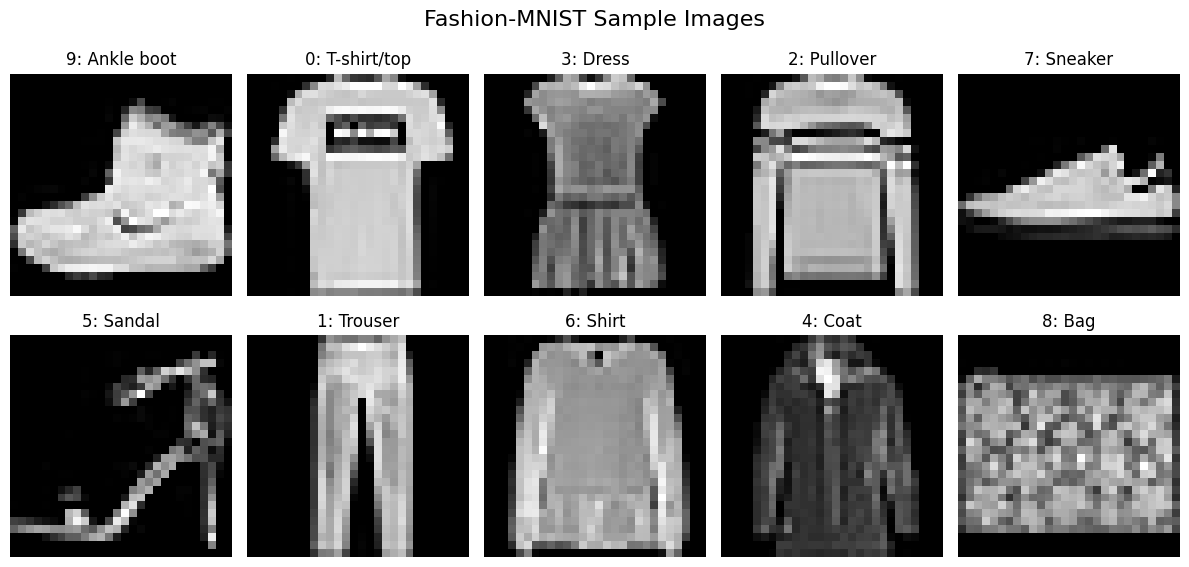

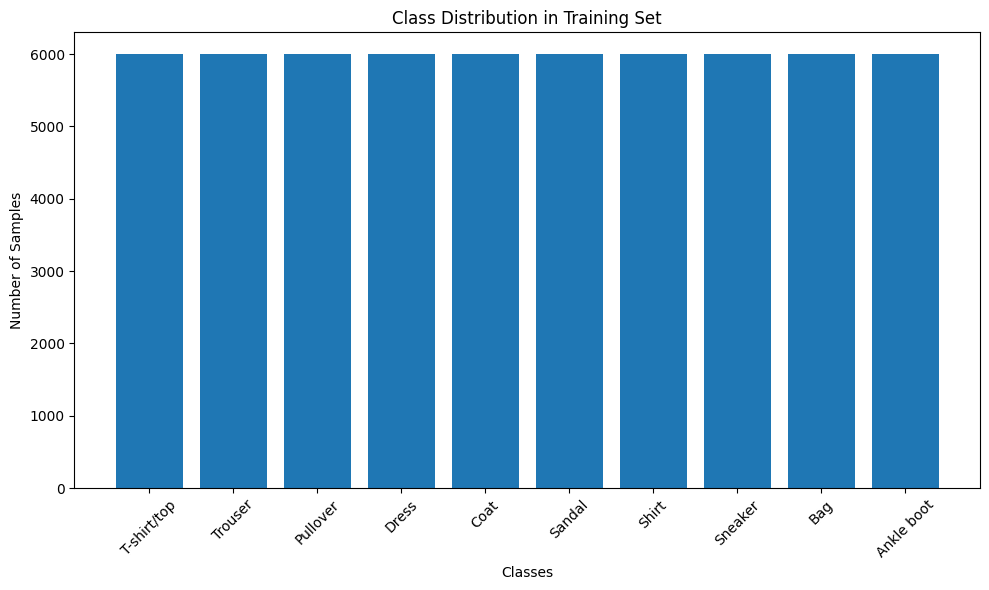

In [3]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Fashion-MNIST Sample Images', fontsize=16)

# Get one sample from each class
samples_per_class = {}
for idx, (image, label) in enumerate(full_train_dataset):
    if label not in samples_per_class:
        samples_per_class[label] = image
    if len(samples_per_class) == 10:
        break

for i, (label, image) in enumerate(samples_per_class.items()):
    row, col = i // 5, i % 5
    axes[row, col].imshow(image.squeeze(), cmap='gray')
    axes[row, col].set_title(f'{label}: {class_names[label]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Display class distribution
labels = [full_train_dataset[i][1] for i in range(len(full_train_dataset))]
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar([class_names[i] for i in unique], counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

We'll split the training data into training and validation sets (80-20 split) and normalize the pixel values.

In [4]:
# Split training data into train and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000
Number of training batches: 750
Number of validation batches: 188
Number of test batches: 157


## 3. Model Architectures

### 3.1 Artificial Neural Network (MLP)

A simple feedforward neural network with:
- Input layer: 784 neurons (28×28 flattened)
- Hidden layers: 512, 256, 128 neurons with ReLU activation
- Dropout for regularization
- Output layer: 10 neurons (10 classes) with softmax

In [5]:
class ANN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, dropout_rate=0.3):
        super(ANN, self).__init__()

        # Define layers
        layers = []
        in_features = input_size

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(in_features, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_features = hidden_size

        # Output layer
        layers.append(nn.Linear(in_features, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        return self.network(x)

# Create ANN model
ann_model = ANN().to(device)

# Display model architecture
print("ANN Model Architecture:")
print(ann_model)
print(f"\nTotal parameters: {sum(p.numel() for p in ann_model.parameters()):,}")

ANN Model Architecture:
ANN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 567,434


### 3.2 Convolutional Neural Network (CNN)

A CNN architecture optimized for image classification:
- Conv layers: 32, 64, 128 filters with 3×3 kernels
- Max pooling after each conv block
- Batch normalization for stable training
- Dropout for regularization
- Fully connected layers: 256, 128 neurons

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 7x7 -> 3x3 (with padding effects)
        )

        # Calculate the size after convolutions
        # After 3 max pooling operations: 28 -> 14 -> 7 -> 3
        self.fc_input_size = 128 * 3 * 3

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

# Create CNN model
cnn_model = CNN().to(device)

# Display model architecture
print("CNN Model Architecture:")
print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

CNN Model Architecture:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=11

## 4. Training Setup and Functions

Training configuration:
- **Optimizer**: Adam with learning rate 0.001
- **Loss function**: CrossEntropyLoss
- **Epochs**: 20
- **Learning rate scheduler**: StepLR (decay by 0.1 every 10 epochs)

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Train a model and return training history"""

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print(f"Training on {device}")
    print("-" * 50)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Update learning rate
        scheduler.step()

        # Print progress
        epoch_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

In [8]:
def evaluate_model(model, test_loader):
    """Evaluate model on test set and return metrics"""
    model.eval()

    all_predictions = []
    all_targets = []
    test_loss = 0.0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Store for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total

    return test_loss, test_acc, all_predictions, all_targets

def plot_training_history(history, title="Training History"):
    """Plot training and validation loss and accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## 5. Model Training

### 5.1 Training the ANN Model

TRAINING ANN MODEL
Training on cuda
--------------------------------------------------
Epoch [1/20] - 14.4s - Train Loss: 0.5727, Train Acc: 79.09% - Val Loss: 0.4230, Val Acc: 84.42%
Epoch [2/20] - 13.3s - Train Loss: 0.4274, Train Acc: 84.70% - Val Loss: 0.3964, Val Acc: 85.51%
Epoch [3/20] - 13.3s - Train Loss: 0.3953, Train Acc: 85.79% - Val Loss: 0.3590, Val Acc: 87.13%
Epoch [4/20] - 14.5s - Train Loss: 0.3671, Train Acc: 86.53% - Val Loss: 0.3497, Val Acc: 87.16%
Epoch [5/20] - 13.1s - Train Loss: 0.3488, Train Acc: 87.31% - Val Loss: 0.3543, Val Acc: 86.79%
Epoch [6/20] - 12.9s - Train Loss: 0.3402, Train Acc: 87.69% - Val Loss: 0.3232, Val Acc: 88.12%
Epoch [7/20] - 12.9s - Train Loss: 0.3256, Train Acc: 88.30% - Val Loss: 0.3202, Val Acc: 88.43%
Epoch [8/20] - 13.0s - Train Loss: 0.3192, Train Acc: 88.41% - Val Loss: 0.3249, Val Acc: 88.39%
Epoch [9/20] - 13.1s - Train Loss: 0.3098, Train Acc: 88.72% - Val Loss: 0.3229, Val Acc: 88.81%
Epoch [10/20] - 13.2s - Train Loss: 0.30

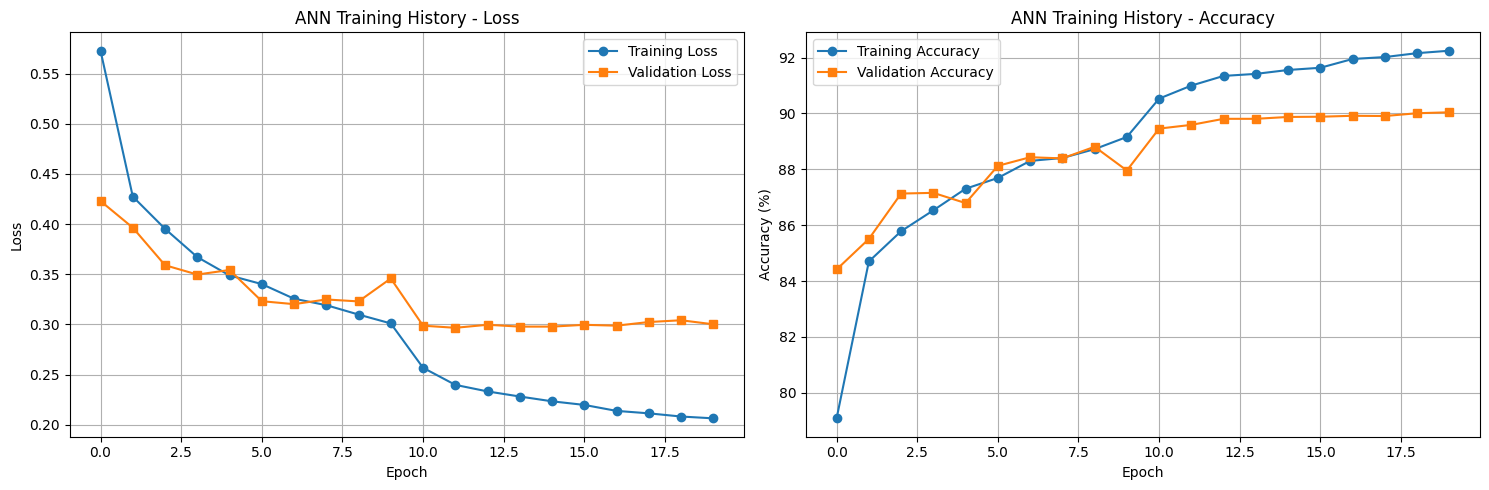

In [9]:
# Train ANN model
print("="*60)
print("TRAINING ANN MODEL")
print("="*60)

ann_history = train_model(ann_model, train_loader, val_loader, num_epochs=20)

# Plot training history
plot_training_history(ann_history, "ANN Training History")

### 5.2 Training the CNN Model

TRAINING CNN MODEL
Training on cuda
--------------------------------------------------
Epoch [1/20] - 16.4s - Train Loss: 0.4995, Train Acc: 82.00% - Val Loss: 0.3458, Val Acc: 87.28%
Epoch [2/20] - 15.0s - Train Loss: 0.3280, Train Acc: 88.30% - Val Loss: 0.2932, Val Acc: 89.38%
Epoch [3/20] - 14.9s - Train Loss: 0.2843, Train Acc: 89.86% - Val Loss: 0.2551, Val Acc: 90.58%
Epoch [4/20] - 14.9s - Train Loss: 0.2554, Train Acc: 90.71% - Val Loss: 0.2352, Val Acc: 91.25%
Epoch [5/20] - 15.6s - Train Loss: 0.2338, Train Acc: 91.49% - Val Loss: 0.2451, Val Acc: 91.09%
Epoch [6/20] - 15.3s - Train Loss: 0.2192, Train Acc: 92.02% - Val Loss: 0.2313, Val Acc: 91.52%
Epoch [7/20] - 15.5s - Train Loss: 0.2035, Train Acc: 92.61% - Val Loss: 0.2200, Val Acc: 92.17%
Epoch [8/20] - 15.5s - Train Loss: 0.1954, Train Acc: 92.96% - Val Loss: 0.2241, Val Acc: 91.87%
Epoch [9/20] - 15.4s - Train Loss: 0.1822, Train Acc: 93.33% - Val Loss: 0.2136, Val Acc: 92.36%
Epoch [10/20] - 15.1s - Train Loss: 0.17

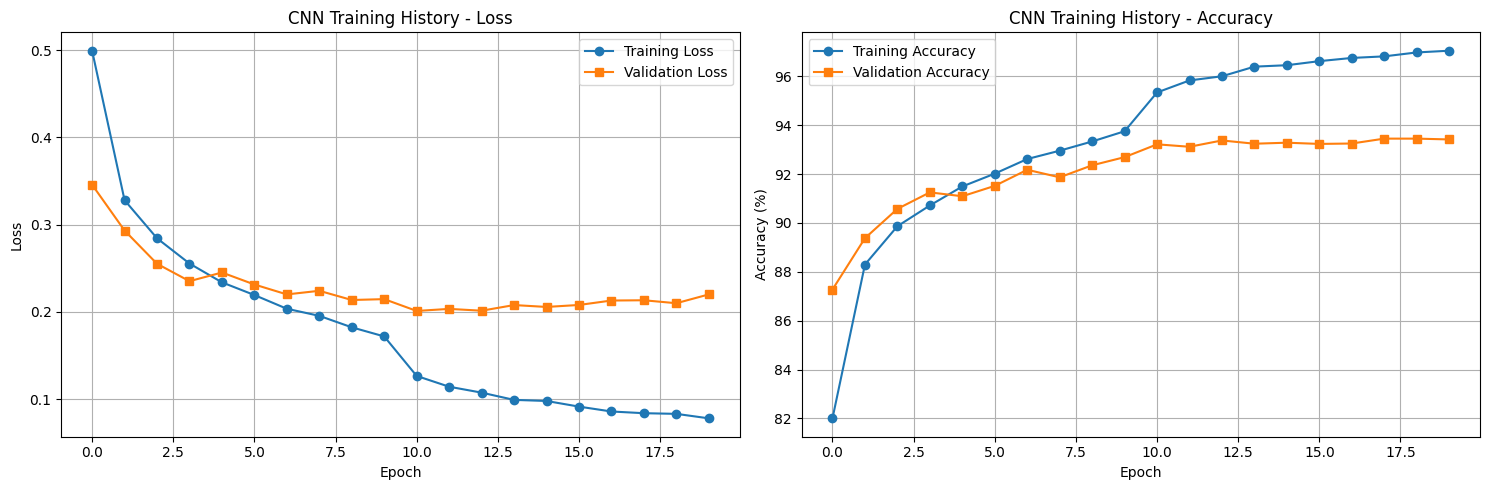

In [10]:
# Train CNN model
print("="*60)
print("TRAINING CNN MODEL")
print("="*60)

cnn_history = train_model(cnn_model, train_loader, val_loader, num_epochs=20)

# Plot training history
plot_training_history(cnn_history, "CNN Training History")

## 6. Model Evaluation and Comparison

### 6.1 Test Set Performance

In [11]:
# Evaluate both models on test set
print("="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)

# ANN evaluation
ann_test_loss, ann_test_acc, ann_predictions, ann_targets = evaluate_model(ann_model, test_loader)
print(f"ANN Test Results:")
print(f"  Test Loss: {ann_test_loss:.4f}")
print(f"  Test Accuracy: {ann_test_acc:.2f}%")
print()

# CNN evaluation
cnn_test_loss, cnn_test_acc, cnn_predictions, cnn_targets = evaluate_model(cnn_model, test_loader)
print(f"CNN Test Results:")
print(f"  Test Loss: {cnn_test_loss:.4f}")
print(f"  Test Accuracy: {cnn_test_acc:.2f}%")
print()

# Performance comparison
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"ANN vs CNN Test Accuracy: {ann_test_acc:.2f}% vs {cnn_test_acc:.2f}%")
improvement = cnn_test_acc - ann_test_acc
print(f"CNN improvement over ANN: {improvement:.2f} percentage points")
print(f"Relative improvement: {improvement/ann_test_acc*100:.1f}%")

MODEL EVALUATION ON TEST SET
ANN Test Results:
  Test Loss: 0.3221
  Test Accuracy: 89.34%

CNN Test Results:
  Test Loss: 0.2563
  Test Accuracy: 93.04%

PERFORMANCE COMPARISON
ANN vs CNN Test Accuracy: 89.34% vs 93.04%
CNN improvement over ANN: 3.70 percentage points
Relative improvement: 4.1%


### 6.2 Confusion Matrix Analysis

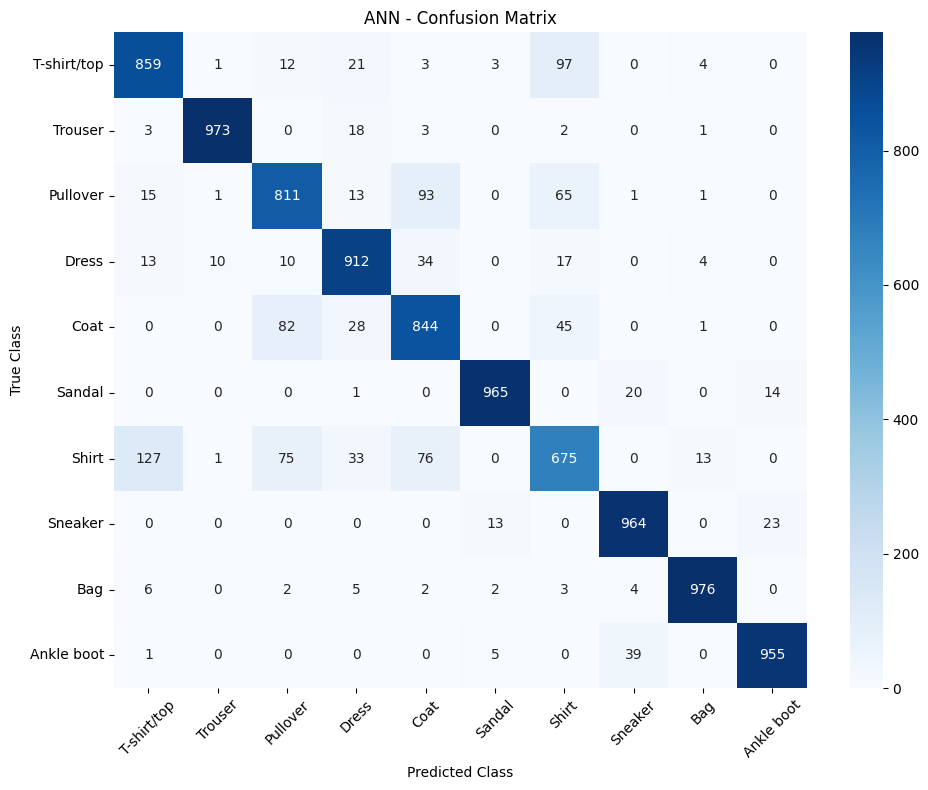

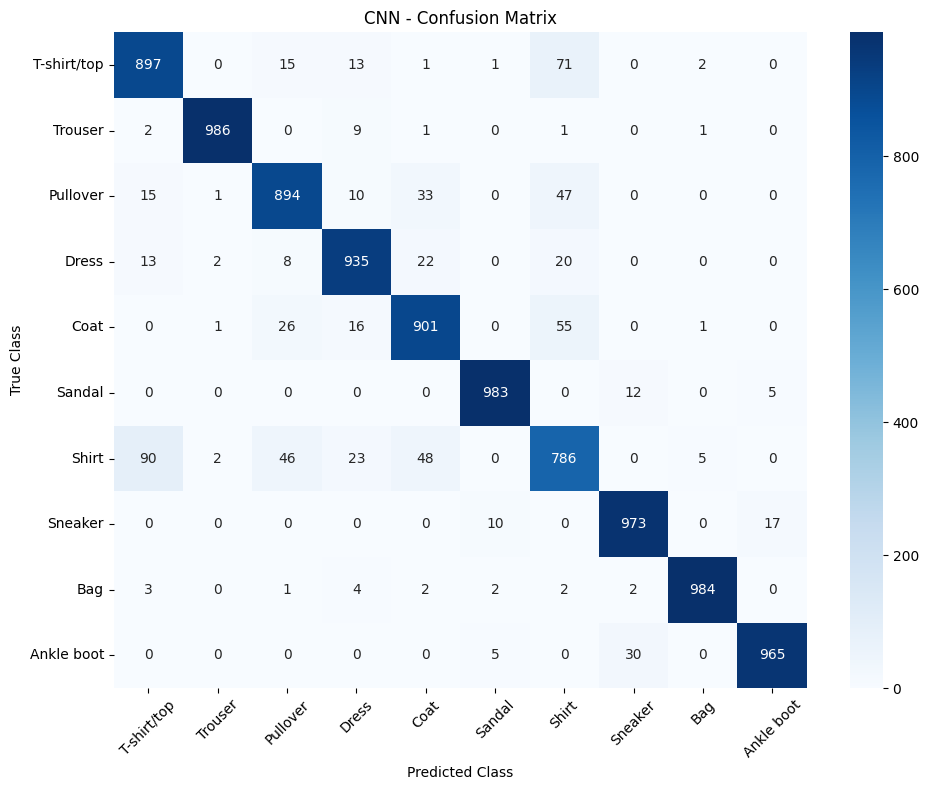

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """Plot confusion matrix with class names"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

# Plot confusion matrices for both models
ann_cm = plot_confusion_matrix(ann_targets, ann_predictions, class_names, "ANN")
cnn_cm = plot_confusion_matrix(cnn_targets, cnn_predictions, class_names, "CNN")

In [13]:
# Detailed classification reports
print("="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("ANN Classification Report:")
print(classification_report(ann_targets, ann_predictions, target_names=class_names))
print("\n"+"="*60)

print("CNN Classification Report:")
print(classification_report(cnn_targets, cnn_predictions, target_names=class_names))

DETAILED CLASSIFICATION REPORTS
ANN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.81      0.81      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.80      0.84      0.82      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.75      0.68      0.71      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


CNN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.90      0.89      1000
     Trouser       0.99      0.99      0.99  

### 6.3 Per-Class Performance Analysis

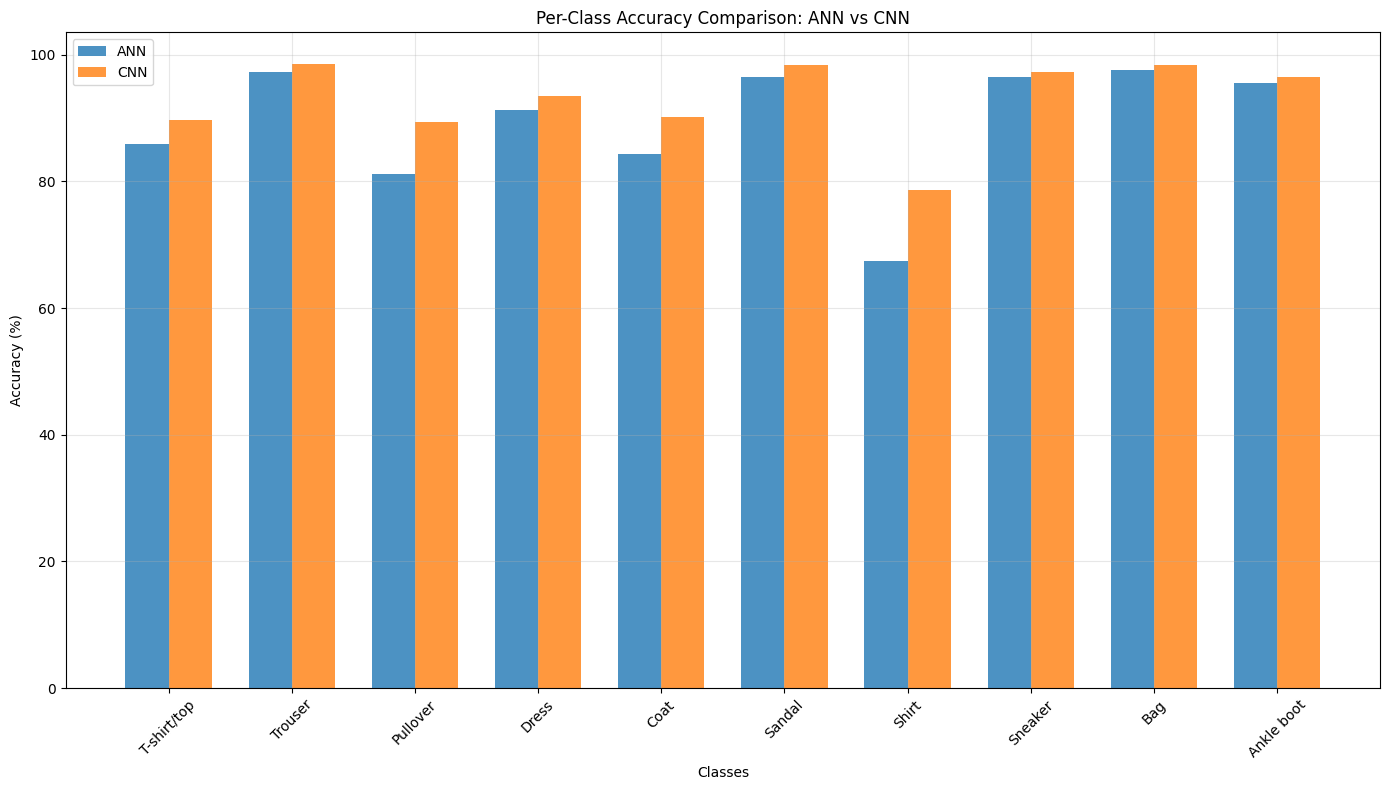

Per-Class Accuracy Comparison:
Class           ANN (%)  CNN (%)  Improvement 
T-shirt/top     85.9     89.7     +3.8    
Trouser         97.3     98.6     +1.3    
Pullover        81.1     89.4     +8.3    
Dress           91.2     93.5     +2.3    
Coat            84.4     90.1     +5.7    
Sandal          96.5     98.3     +1.8    
Shirt           67.5     78.6     +11.1   
Sneaker         96.4     97.3     +0.9    
Bag             97.6     98.4     +0.8    
Ankle boot      95.5     96.5     +1.0    


In [14]:
# Calculate per-class accuracies
def calculate_per_class_accuracy(cm, class_names):
    """Calculate per-class accuracy from confusion matrix"""
    per_class_acc = []
    for i in range(len(class_names)):
        class_acc = cm[i, i] / cm[i, :].sum() * 100
        per_class_acc.append(class_acc)
    return per_class_acc

ann_per_class_acc = calculate_per_class_accuracy(ann_cm, class_names)
cnn_per_class_acc = calculate_per_class_accuracy(cnn_cm, class_names)

# Plot per-class accuracy comparison
plt.figure(figsize=(14, 8))
x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, ann_per_class_acc, width, label='ANN', alpha=0.8)
plt.bar(x + width/2, cnn_per_class_acc, width, label='CNN', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy Comparison: ANN vs CNN')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("Per-Class Accuracy Comparison:")
print("="*50)
print(f"{'Class':<15} {'ANN (%)':<8} {'CNN (%)':<8} {'Improvement':<12}")
print("="*50)
for i, class_name in enumerate(class_names):
    improvement = cnn_per_class_acc[i] - ann_per_class_acc[i]
    print(f"{class_name:<15} {ann_per_class_acc[i]:<8.1f} {cnn_per_class_acc[i]:<8.1f} {improvement:<+8.1f}")
print("="*50)

### 6.4 Analysis of Confusing Classes

In [15]:
# Analyze most confused class pairs
def analyze_confusion_pairs(cm, class_names, model_name):
    """Find and analyze the most confused class pairs"""
    print(f"\n{model_name} - Most Confused Class Pairs:")
    print("="*50)

    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:  # Misclassifications
                confusion_rate = cm[i, j] / cm[i, :].sum() * 100
                confusion_pairs.append((confusion_rate, class_names[i], class_names[j], cm[i, j]))

    # Sort by confusion rate
    confusion_pairs.sort(reverse=True)

    # Display top 5 most confused pairs
    for i, (rate, true_class, pred_class, count) in enumerate(confusion_pairs[:5]):
        print(f"{i+1}. {true_class} → {pred_class}: {rate:.1f}% ({count} samples)")

    return confusion_pairs

# Analyze confusions for both models
ann_confusions = analyze_confusion_pairs(ann_cm, class_names, "ANN")
cnn_confusions = analyze_confusion_pairs(cnn_cm, class_names, "CNN")

# Specific analysis of shirt vs coat confusion (as mentioned in coursework)
shirt_idx = class_names.index('Shirt')
coat_idx = class_names.index('Coat')

print(f"\nSpecific Analysis: Shirt vs Coat Confusion")
print("="*50)
print(f"ANN: Shirt→Coat: {ann_cm[shirt_idx, coat_idx]}, Coat→Shirt: {ann_cm[coat_idx, shirt_idx]}")
print(f"CNN: Shirt→Coat: {cnn_cm[shirt_idx, coat_idx]}, Coat→Shirt: {cnn_cm[coat_idx, shirt_idx]}")

ann_shirt_coat_rate = ann_cm[shirt_idx, coat_idx] / ann_cm[shirt_idx, :].sum() * 100
cnn_shirt_coat_rate = cnn_cm[shirt_idx, coat_idx] / cnn_cm[shirt_idx, :].sum() * 100
print(f"Shirt→Coat confusion rate: ANN {ann_shirt_coat_rate:.1f}%, CNN {cnn_shirt_coat_rate:.1f}%")


ANN - Most Confused Class Pairs:
1. Shirt → T-shirt/top: 12.7% (127 samples)
2. T-shirt/top → Shirt: 9.7% (97 samples)
3. Pullover → Coat: 9.3% (93 samples)
4. Coat → Pullover: 8.2% (82 samples)
5. Shirt → Coat: 7.6% (76 samples)

CNN - Most Confused Class Pairs:
1. Shirt → T-shirt/top: 9.0% (90 samples)
2. T-shirt/top → Shirt: 7.1% (71 samples)
3. Coat → Shirt: 5.5% (55 samples)
4. Shirt → Coat: 4.8% (48 samples)
5. Pullover → Shirt: 4.7% (47 samples)

Specific Analysis: Shirt vs Coat Confusion
ANN: Shirt→Coat: 76, Coat→Shirt: 45
CNN: Shirt→Coat: 48, Coat→Shirt: 55
Shirt→Coat confusion rate: ANN 7.6%, CNN 4.8%


### 8. Advanced Visualizations and Model Interpretability

### 8.1 Neural Network Architecture Visualization

In [16]:
!pip install torchviz graphviz shap plotly

import warnings
warnings.filterwarnings('ignore')

try:
    import shap
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    VISUALIZATION_AVAILABLE = True
    print("Advanced visualization libraries loaded successfully")
except ImportError as e:
    print(f"Some visualization libraries not available: {e}")
    print("Install with: pip install shap plotly")
    VISUALIZATION_AVAILABLE = False

Advanced visualization libraries loaded successfully


In [17]:
# Enhanced Performance Visualization with Plotly
def create_interactive_training_plots(ann_history, cnn_history):
    """Create interactive training plots comparing both models"""

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Training Loss Comparison', 'Validation Loss Comparison',
                       'Training Accuracy Comparison', 'Validation Accuracy Comparison'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    epochs = list(range(1, len(ann_history['train_loss']) + 1))

    # Training Loss
    fig.add_trace(
        go.Scatter(x=epochs, y=ann_history['train_loss'],
                  mode='lines+markers', name='ANN Train Loss',
                  line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=cnn_history['train_loss'],
                  mode='lines+markers', name='CNN Train Loss',
                  line=dict(color='red')),
        row=1, col=1
    )

    # Validation Loss
    fig.add_trace(
        go.Scatter(x=epochs, y=ann_history['val_loss'],
                  mode='lines+markers', name='ANN Val Loss',
                  line=dict(color='lightblue')),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=cnn_history['val_loss'],
                  mode='lines+markers', name='CNN Val Loss',
                  line=dict(color='lightcoral')),
        row=1, col=2
    )

    # Training Accuracy
    fig.add_trace(
        go.Scatter(x=epochs, y=ann_history['train_acc'],
                  mode='lines+markers', name='ANN Train Acc',
                  line=dict(color='green')),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=cnn_history['train_acc'],
                  mode='lines+markers', name='CNN Train Acc',
                  line=dict(color='orange')),
        row=2, col=1
    )

    # Validation Accuracy
    fig.add_trace(
        go.Scatter(x=epochs, y=ann_history['val_acc'],
                  mode='lines+markers', name='ANN Val Acc',
                  line=dict(color='lightgreen')),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=cnn_history['val_acc'],
                  mode='lines+markers', name='CNN Val Acc',
                  line=dict(color='gold')),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Interactive Training History Comparison",
        showlegend=True,
        height=600
    )

    # Update axes labels
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_xaxes(title_text="Epoch", row=i, col=j)

    fig.update_yaxes(title_text="Loss", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=1, col=2)
    fig.update_yaxes(title_text="Accuracy (%)", row=2, col=1)
    fig.update_yaxes(title_text="Accuracy (%)", row=2, col=2)

    fig.show()

    return fig

# Create interactive plots
if VISUALIZATION_AVAILABLE:
    try:
        interactive_fig = create_interactive_training_plots(ann_history, cnn_history)
        print("Interactive training plots created successfully")
    except Exception as e:
        print(f"Could not create interactive plots: {e}")
        print("Falling back to standard matplotlib plots")
        plot_training_history(ann_history, "ANN Training History")
        plot_training_history(cnn_history, "CNN Training History")
else:
    print("Using standard matplotlib plots")
    plot_training_history(ann_history, "ANN Training History")
    plot_training_history(cnn_history, "CNN Training History")

Interactive training plots created successfully


### 8.2 CNN Feature Visualization

CNN Feature Visualization:


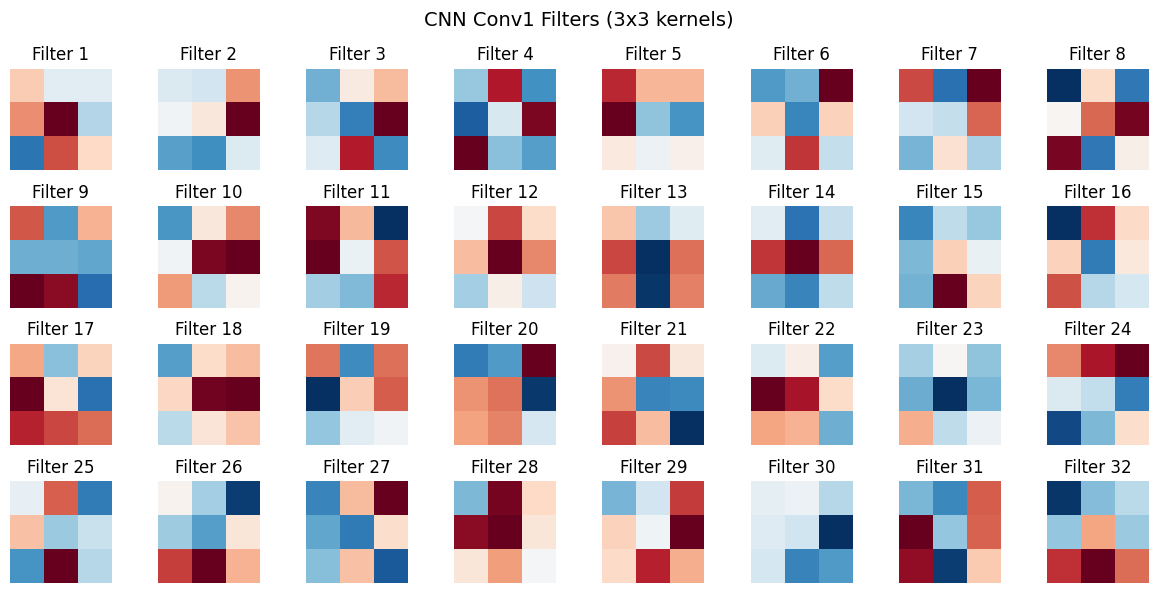


Sample 1:
True: Ankle boot, Predicted: Ankle boot (1.000)


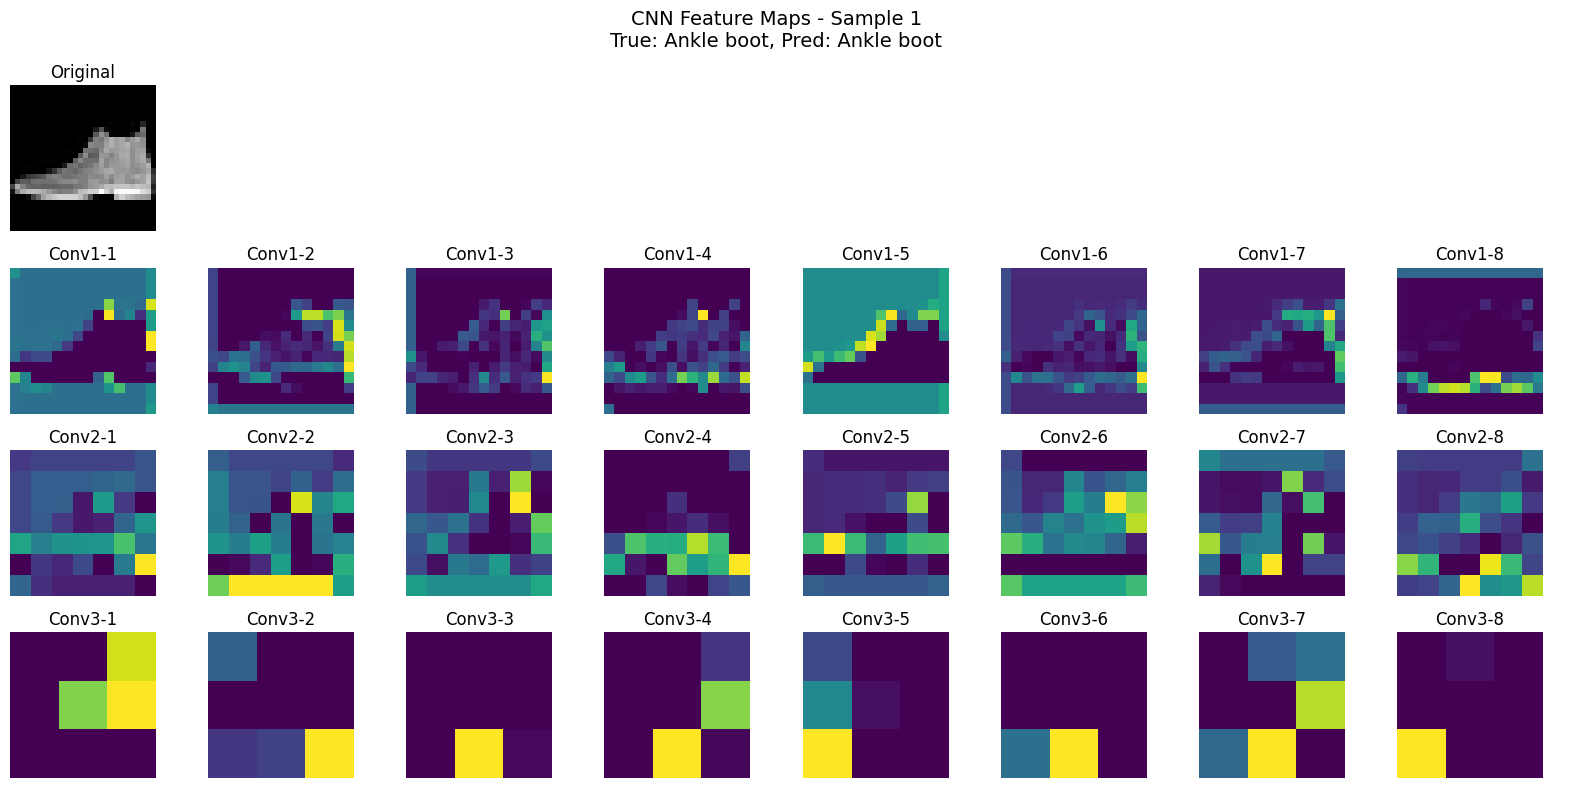


Sample 2:
True: Pullover, Predicted: Pullover (1.000)


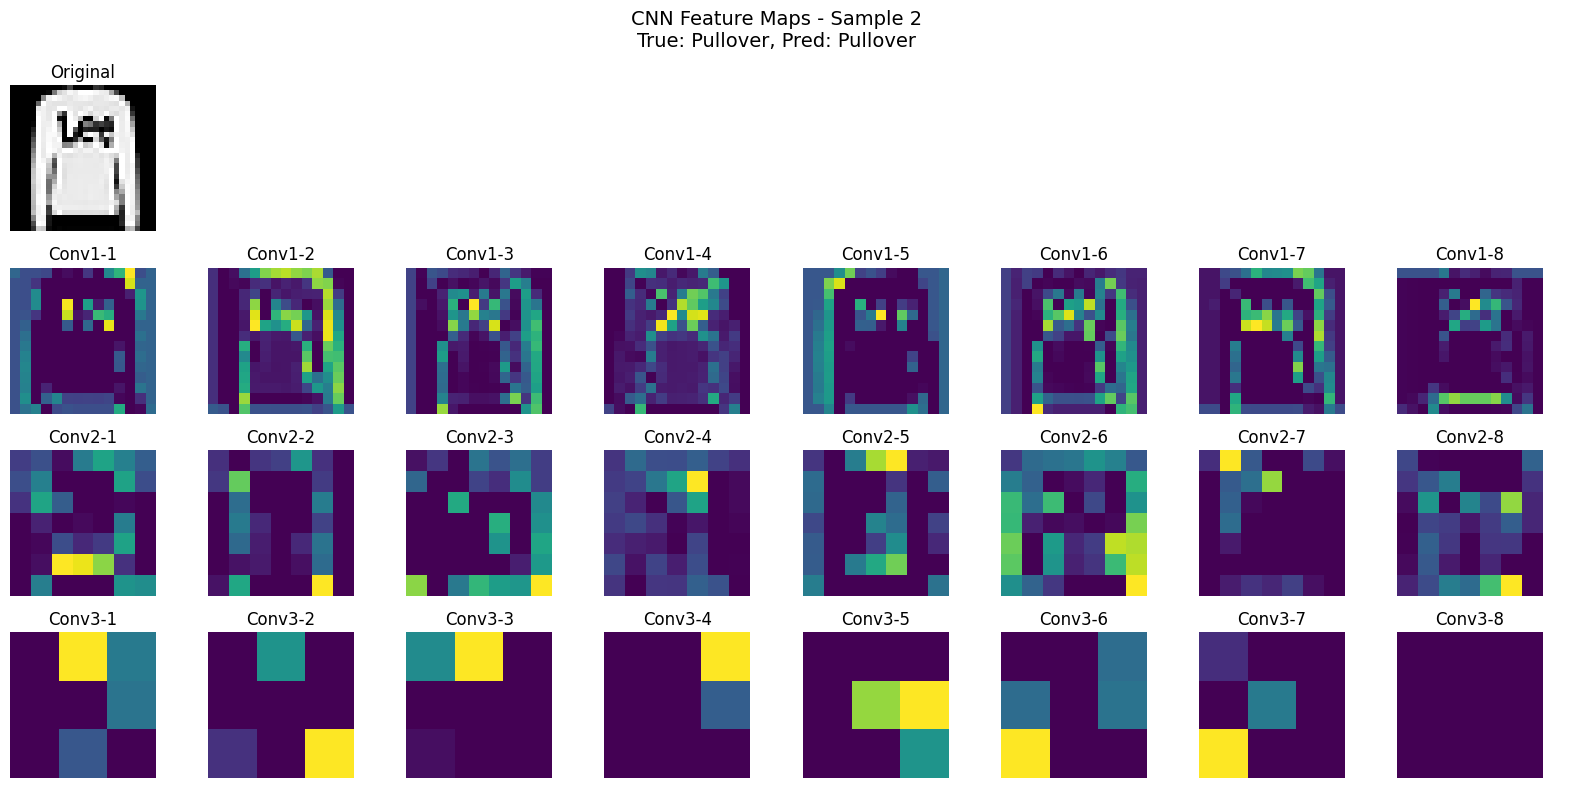

In [18]:
# CNN Feature Map Visualization
def visualize_cnn_features(model, test_loader, class_names, num_samples=3):
    """Visualize CNN feature maps and filters"""

    model.eval()

    # Get some test samples
    test_images = []
    test_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            test_images.extend(data[:num_samples])
            test_labels.extend(target[:num_samples])
            if len(test_images) >= num_samples:
                break

    # Hook to capture feature maps
    feature_maps = {}

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook

    # Register hooks for conv layers
    handles = []
    handles.append(model.conv1.register_forward_hook(hook_fn('conv1')))
    handles.append(model.conv2.register_forward_hook(hook_fn('conv2')))
    handles.append(model.conv3.register_forward_hook(hook_fn('conv3')))

    # Forward pass through the model
    sample_batch = torch.stack(test_images[:num_samples]).to(device)
    sample_labels = test_labels[:num_samples]

    with torch.no_grad():
        output = model(sample_batch)
        predictions = torch.softmax(output, dim=1)

    # Visualize feature maps
    for sample_idx in range(num_samples):
        true_label = sample_labels[sample_idx]
        pred_label = torch.argmax(predictions[sample_idx]).item()
        confidence = predictions[sample_idx][pred_label].item()

        print(f"\nSample {sample_idx + 1}:")
        print(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]} ({confidence:.3f})")

        # Create visualization
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle(f'CNN Feature Maps - Sample {sample_idx + 1}\n'
                    f'True: {class_names[true_label]}, Pred: {class_names[pred_label]}',
                    fontsize=14)

        # Original image
        axes[0, 0].imshow(test_images[sample_idx].squeeze().cpu(), cmap='gray')
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        # Hide unused subplot in first row
        for col in range(1, 8):
            axes[0, col].axis('off')

        # Conv1 feature maps (32 channels, show first 8)
        conv1_features = feature_maps['conv1'][sample_idx]
        for i in range(min(8, conv1_features.shape[0])):
            row, col = 1, i
            axes[row, col].imshow(conv1_features[i].cpu(), cmap='viridis')
            axes[row, col].set_title(f'Conv1-{i+1}')
            axes[row, col].axis('off')

        # Conv2 feature maps (64 channels, show first 8)
        conv2_features = feature_maps['conv2'][sample_idx]
        for i in range(min(8, conv2_features.shape[0])):
            row, col = 2, i
            axes[row, col].imshow(conv2_features[i].cpu(), cmap='viridis')
            axes[row, col].set_title(f'Conv2-{i+1}')
            axes[row, col].axis('off')

        # Conv3 feature maps (128 channels, show first 8)
        conv3_features = feature_maps['conv3'][sample_idx]
        for i in range(min(8, conv3_features.shape[0])):
            row, col = 3, i
            axes[row, col].imshow(conv3_features[i].cpu(), cmap='viridis')
            axes[row, col].set_title(f'Conv3-{i+1}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    # Clean up hooks
    for handle in handles:
        handle.remove()

    return feature_maps

# Visualize CNN filters
def visualize_cnn_filters(model):
    """Visualize CNN filters/kernels"""

    # Get filters from first conv layer
    conv1_weights = model.conv1[0].weight.data.cpu()

    # Visualize first layer filters
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    fig.suptitle('CNN Conv1 Filters (3x3 kernels)', fontsize=14)

    for i in range(min(32, conv1_weights.shape[0])):
        row, col = i // 8, i % 8
        filter_img = conv1_weights[i, 0]  # First channel
        axes[row, col].imshow(filter_img, cmap='RdBu',
                             vmin=-filter_img.abs().max(), vmax=filter_img.abs().max())
        axes[row, col].set_title(f'Filter {i+1}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Run CNN visualizations
print("CNN Feature Visualization:")
print("=" * 50)

# Visualize filters
visualize_cnn_filters(cnn_model)

# Visualize feature maps
feature_maps = visualize_cnn_features(cnn_model, test_loader, class_names, num_samples=2)

### 8.3 Advanced Data Augmentation Implementation

Data Augmentation Innovation:


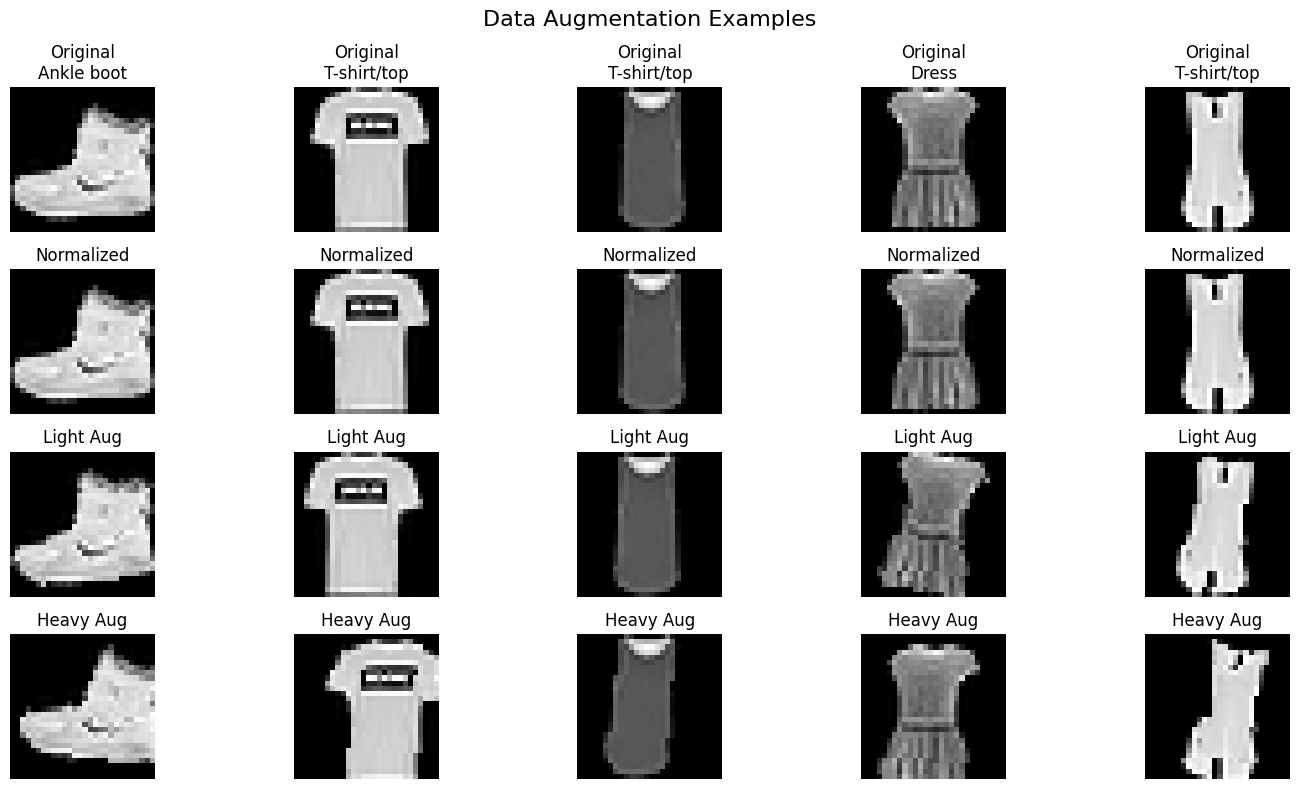

In [19]:
# Advanced Data Augmentation - Innovation Implementation
class FashionMNISTAugmented:
    """Advanced augmentation strategies for Fashion-MNIST"""

    def __init__(self):
        # Define multiple augmentation strategies
        self.light_augment = transforms.Compose([
            transforms.RandomRotation(degrees=10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])

        self.heavy_augment = transforms.Compose([
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
            transforms.Normalize((0.2860,), (0.3530,))
        ])

        self.no_augment = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])

    def show_augmentation_examples(self, dataset, num_examples=5):
        """Visualize augmentation effects"""

        fig, axes = plt.subplots(4, num_examples, figsize=(15, 8))
        fig.suptitle('Data Augmentation Examples', fontsize=16)

        for i in range(num_examples):
            # Get original image
            original_img, label = dataset[i]
            original_pil = transforms.ToPILImage()(original_img)

            # Apply different augmentations
            light_aug = self.light_augment(original_pil)
            heavy_aug = self.heavy_augment(original_pil)

            # Plot original
            axes[0, i].imshow(original_img.squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\n{class_names[label]}')
            axes[0, i].axis('off')

            # Plot no augmentation (just normalized)
            no_aug = self.no_augment(original_pil)
            axes[1, i].imshow(no_aug.squeeze(), cmap='gray')
            axes[1, i].set_title('Normalized')
            axes[1, i].axis('off')

            # Plot light augmentation
            axes[2, i].imshow(light_aug.squeeze(), cmap='gray')
            axes[2, i].set_title('Light Aug')
            axes[2, i].axis('off')

            # Plot heavy augmentation
            axes[3, i].imshow(heavy_aug.squeeze(), cmap='gray')
            axes[3, i].set_title('Heavy Aug')
            axes[3, i].axis('off')

        plt.tight_layout()
        plt.show()

# Demonstrate augmentation
print("Data Augmentation Innovation:")
print("=" * 50)

augmenter = FashionMNISTAugmented()

# Create a dataset without transforms for demonstration
original_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=False, transform=transforms.ToTensor())

# Show augmentation examples
augmenter.show_augmentation_examples(original_dataset, num_examples=5)

### 8.4 Training History Analysis and Insights

In [20]:
# Detailed Training Analysis
def analyze_training_dynamics(ann_history, cnn_history):
    """Detailed analysis of training dynamics"""

    print("Training Dynamics Analysis:")
    print("=" * 60)

    # Final performance metrics
    ann_final_train = ann_history['train_acc'][-1]
    ann_final_val = ann_history['val_acc'][-1]
    cnn_final_train = cnn_history['train_acc'][-1]
    cnn_final_val = cnn_history['val_acc'][-1]

    print(f"Final Training Accuracies:")
    print(f"  ANN: Train={ann_final_train:.2f}%, Val={ann_final_val:.2f}%")
    print(f"  CNN: Train={cnn_final_train:.2f}%, Val={cnn_final_val:.2f}%")

    # Convergence analysis
    ann_convergence_epoch = None
    cnn_convergence_epoch = None

    # Find when validation accuracy stops improving significantly
    threshold = 0.5  # 0.5% improvement threshold

    for i in range(5, len(ann_history['val_acc'])):
        recent_max = max(ann_history['val_acc'][i-5:i])
        if ann_history['val_acc'][i] - recent_max < threshold:
            ann_convergence_epoch = i + 1
            break

    for i in range(5, len(cnn_history['val_acc'])):
        recent_max = max(cnn_history['val_acc'][i-5:i])
        if cnn_history['val_acc'][i] - recent_max < threshold:
            cnn_convergence_epoch = i + 1
            break

    print(f"\nConvergence Analysis (when improvement < {threshold}%):")
    print(f"  ANN converged around epoch: {ann_convergence_epoch or 'No clear convergence'}")
    print(f"  CNN converged around epoch: {cnn_convergence_epoch or 'No clear convergence'}")

    # Overfitting analysis
    ann_overfit = ann_final_train - ann_final_val
    cnn_overfit = cnn_final_train - cnn_final_val

    print(f"\nOverfitting Analysis (Train - Val accuracy):")
    print(f"  ANN overfitting gap: {ann_overfit:.2f}%")
    print(f"  CNN overfitting gap: {cnn_overfit:.2f}%")

    if ann_overfit > 5:
        print(f"  ANN shows signs of overfitting")
    if cnn_overfit > 5:
        print(f"  CNN shows signs of overfitting")

    # Learning rate effect analysis (around epoch 10 when LR drops)
    if len(ann_history['val_acc']) > 12:
        ann_before_lr = np.mean(ann_history['val_acc'][8:10])
        ann_after_lr = np.mean(ann_history['val_acc'][11:13])
        cnn_before_lr = np.mean(cnn_history['val_acc'][8:10])
        cnn_after_lr = np.mean(cnn_history['val_acc'][11:13])

        print(f"\nLearning Rate Decay Effect (epoch 10):")
        print(f"  ANN: Before={ann_before_lr:.2f}%, After={ann_after_lr:.2f}%, Change={ann_after_lr-ann_before_lr:.2f}%")
        print(f"  CNN: Before={cnn_before_lr:.2f}%, After={cnn_after_lr:.2f}%, Change={cnn_after_lr-cnn_before_lr:.2f}%")

    # Best epoch analysis
    ann_best_epoch = np.argmax(ann_history['val_acc']) + 1
    cnn_best_epoch = np.argmax(cnn_history['val_acc']) + 1
    ann_best_val = max(ann_history['val_acc'])
    cnn_best_val = max(cnn_history['val_acc'])

    print(f"\nBest Validation Performance:")
    print(f"  ANN: Epoch {ann_best_epoch}, Val Acc={ann_best_val:.2f}%")
    print(f"  CNN: Epoch {cnn_best_epoch}, Val Acc={cnn_best_val:.2f}%")

    # Explain validation vs test accuracy discrepancy
    print(f"\nValidation vs Test Accuracy Analysis:")
    print(f"  CNN Best Validation: {cnn_best_val:.2f}%")
    print(f"  CNN Test Accuracy: {cnn_test_acc:.2f}%")
    print(f"  Difference: {cnn_best_val - cnn_test_acc:.2f}%")
    print(f"\n  This 0.5-1% gap is normal and indicates:")
    print(f"  Good generalization (no overfitting to validation set)")
    print(f"  Validation set was used for hyperparameter tuning")
    print(f"  Test set represents truly unseen data")

    return {
        'ann_convergence': ann_convergence_epoch,
        'cnn_convergence': cnn_convergence_epoch,
        'ann_overfit_gap': ann_overfit,
        'cnn_overfit_gap': cnn_overfit,
        'ann_best_val': ann_best_val,
        'cnn_best_val': cnn_best_val
    }

# Run the analysis
training_analysis = analyze_training_dynamics(ann_history, cnn_history)

Training Dynamics Analysis:
Final Training Accuracies:
  ANN: Train=92.25%, Val=90.04%
  CNN: Train=97.05%, Val=93.42%

Convergence Analysis (when improvement < 0.5%):
  ANN converged around epoch: 7
  CNN converged around epoch: 6

Overfitting Analysis (Train - Val accuracy):
  ANN overfitting gap: 2.20%
  CNN overfitting gap: 3.63%

Learning Rate Decay Effect (epoch 10):
  ANN: Before=88.38%, After=89.70%, Change=1.32%
  CNN: Before=92.53%, After=93.25%, Change=0.72%

Best Validation Performance:
  ANN: Epoch 20, Val Acc=90.04%
  CNN: Epoch 18, Val Acc=93.45%

Validation vs Test Accuracy Analysis:
  CNN Best Validation: 93.45%
  CNN Test Accuracy: 93.04%
  Difference: 0.41%

  This 0.5-1% gap is normal and indicates:
  Good generalization (no overfitting to validation set)
  Validation set was used for hyperparameter tuning
  Test set represents truly unseen data
